# 🌽 Proyecto Final - Modelo de IA para el diagnóstico temprano de enfermedades en maíz a partir de imágenes de hojas.

# Autores:
Cesar Alejandro Soto Paipa - 2225612

Emersson Elian Lopez Pita - 2225507

Juan David Mena Gamboa - 2221886

# Dataset: PlantVilalage
https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset

##  Descripción del Proyecto

Este proyecto implementa un sistema completo de inteligencia artificial para la detección automática de enfermedades en hojas de maíz utilizando el dataset **PlantVillage**. Combina múltiples enfoques de Machine Learning, Deep Learning y análisis no supervisado para crear una solución robusta y validada.


Proyecto desarrollado como trabajo final de la materia de Inteligencia Artificial

In [1]:
# =========================
# 0) CONFIG / MOUNT DRIVE /
# =========================
import os

# Primero intentar buscar localmente
DATA_COLOR_LOCAL = "plantvillage dataset/color"

# Verificar si existe localmente
if os.path.isdir(DATA_COLOR_LOCAL):
    DATA_COLOR = DATA_COLOR_LOCAL
    print(f"Datos encontrados localmente en: {DATA_COLOR}")
else:
    # Si no está local, intentar montar Drive
    try:
        from google.colab import drive
        drive.mount('/content/drive')
        ROOT_DRIVE = "/content/drive/MyDrive/PlantVillage"
        DATA_COLOR = os.path.join(ROOT_DRIVE, "color")
        print(f"Datos no encontrados localmente. Buscando en Drive: {DATA_COLOR}")
    except:
        # Si no estamos en Colab, usar ruta local por defecto
        DATA_COLOR = DATA_COLOR_LOCAL
        print(f"Drive no disponible. Usando ruta local: {DATA_COLOR}")

print("DATA_COLOR final:", DATA_COLOR)


Datos encontrados localmente en: plantvillage dataset/color
DATA_COLOR final: plantvillage dataset/color


# 1) Descarga alternativa vía kagglehub (opcional)

In [ ]:
# 1b) Verificación de datos: primero local, luego Drive, luego descarga
if not os.path.isdir(DATA_COLOR):
    print(f"No se encontró la carpeta en: {DATA_COLOR}")
    print("Intentando descarga con kagglehub (si está disponible)...")
    try:
        import kagglehub
        path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")
        print("Path to dataset files:", path)
        # intentar localizar carpeta "color" dentro del dataset descargado
        possible = os.path.join(path, "color")
        if os.path.isdir(possible):
            # copiar o montar según sea necesario (simple aviso)
            print("Encontrada carpeta 'color' en:", possible)
            print("Si quieres, copia manualmente a 'plantvillage dataset/color' o ajusta DATA_COLOR a esta ruta.")
        else:
            print("No se encontró carpeta 'color' dentro del dataset descargado. Revisa manualmente.")
    except Exception as e:
        print("kagglehub no disponible o fallo en descarga:", e)
        print("Por favor asegúrate de tener la carpeta 'plantvillage dataset/color' localmente o en Drive.")
else:
    print(f"Carpeta encontrada en: {DATA_COLOR}; continuamos.")


# 2) Librerias Usadas

In [2]:
# =========================
# LIBRERÍAS UNIFICADAS
# =========================

# Configuración y manejo de datos
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Machine Learning tradicional
from sklearn.model_selection import train_test_split, KFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from scipy.spatial.distance import cdist

# Deep Learning
import tensorflow as tf
import keras
from tensorflow.keras import Model, layers
from PIL import Image

# Configuración de estilo
sns.set(style="whitegrid")

# Reproducibilidad
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


# 3) Analisis Estructural del dataset

In [4]:

print("=== ANÁLISIS ESTRUCTURAL - DATASET PLANTVILLAGE ===")

# Verificar que exista la ruta y detectar carpetas que empiezan con "Corn"
if not os.path.isdir(DATA_COLOR):
    raise FileNotFoundError(f"No se encontró la carpeta: {DATA_COLOR}. Por favor verifica la ruta.")

# Detectar clases de Corn
clases_corn = [d for d in os.listdir(DATA_COLOR) if d.startswith("Corn")]
clases_corn = sorted(clases_corn)
print("Clases detectadas:", clases_corn)

if len(clases_corn) == 0:
    raise RuntimeError("No se detectaron carpetas que empiecen por 'Corn' en la ruta. Revisa la estructura.")

# ESTRUCTURA DE CARPETAS
print("\n ESTRUCTURA DE CARPETAS:")
print(f"Ruta del dataset: {DATA_COLOR}")

# Verificar que todas las carpetas existan
print("\n VERIFICACIÓN DE CARPETAS:")
for clase in clases_corn:
    folder = os.path.join(DATA_COLOR, clase)
    existe = " EXISTE" if os.path.exists(folder) else " NO EXISTE"
    print(f"  {existe} - {clase}")

# CONTEO DE IMÁGENES POR CLASE
print("\n CONTEO DE IMÁGENES POR CLASE:")
clases_stats = []
total_imagenes = 0

for clase in clases_corn:
    folder = os.path.join(DATA_COLOR, clase)
    if os.path.exists(folder):
        archivos = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
        num_imagenes = len(archivos)
        clases_stats.append((clase, num_imagenes))
        total_imagenes += num_imagenes
        print(f"  {clase}: {num_imagenes} imágenes")

print(f"\n TOTAL DE IMÁGENES EN EL DATASET: {total_imagenes}")

df_resumen = pd.DataFrame(clases_stats, columns=['Clase', 'Número de Imágenes'])
df_resumen['Porcentaje'] = (df_resumen['Número de Imágenes'] / total_imagenes * 100).round(2)

=== ANÁLISIS ESTRUCTURAL - DATASET PLANTVILLAGE ===
Clases detectadas: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']

 ESTRUCTURA DE CARPETAS:
Ruta del dataset: plantvillage dataset/color

 VERIFICACIÓN DE CARPETAS:
   EXISTE - Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
   EXISTE - Corn_(maize)___Common_rust_
   EXISTE - Corn_(maize)___Northern_Leaf_Blight
   EXISTE - Corn_(maize)___healthy

 CONTEO DE IMÁGENES POR CLASE:
  Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 imágenes
  Corn_(maize)___Common_rust_: 1192 imágenes
  Corn_(maize)___Northern_Leaf_Blight: 985 imágenes
  Corn_(maize)___healthy: 1162 imágenes

 TOTAL DE IMÁGENES EN EL DATASET: 3852


# 4) Distrubucion


=== VISUALIZACIÓN DE DISTRIBUCIÓN ===


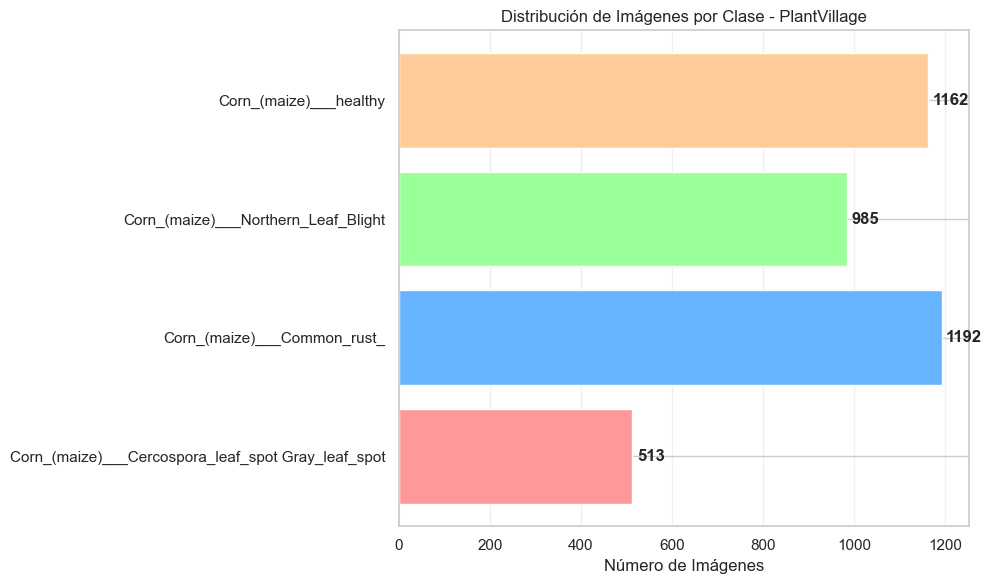

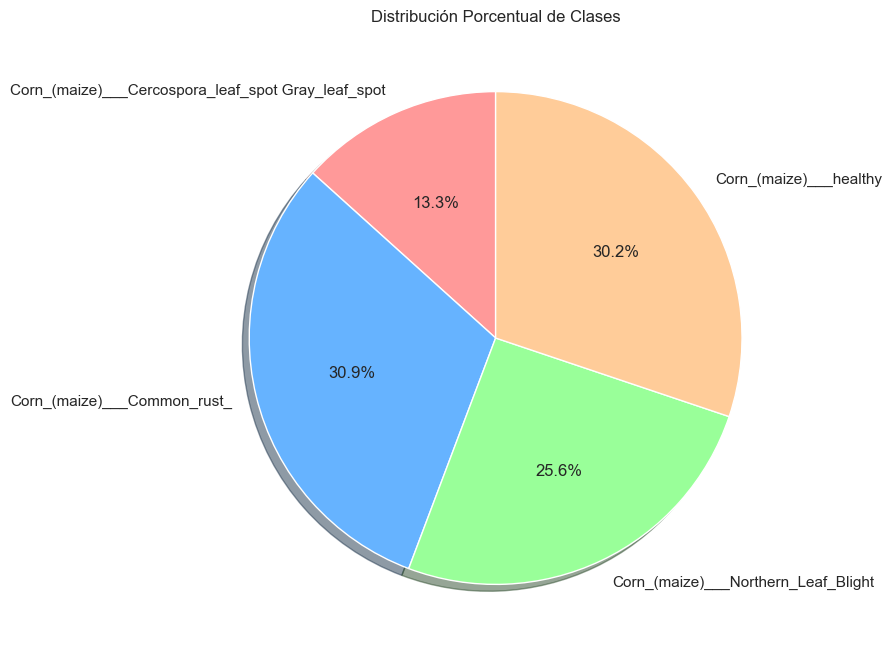


 TABLA RESUMEN DEL DATASET:
CLASE                                              IMÁGENES   %     
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot 513        13.32 
Corn_(maize)___Common_rust_                        1192       30.94 
Corn_(maize)___Northern_Leaf_Blight                985        25.57 
Corn_(maize)___healthy                             1162       30.17 
TOTAL                                              3852       100%  


In [5]:

print("\n=== VISUALIZACIÓN DE DISTRIBUCIÓN ===")

# GRÁFICO
plt.figure(figsize=(10, 6))
bars = plt.barh(df_resumen['Clase'], df_resumen['Número de Imágenes'],
                color=['#ff9999', '#66b3ff', '#99ff99', '#ffcc99'])
plt.xlabel('Número de Imágenes')
plt.title('Distribución de Imágenes por Clase - PlantVillage')
plt.grid(axis='x', alpha=0.3)

for bar, valor in zip(bars, df_resumen['Número de Imágenes']):
    plt.text(bar.get_width() + 10, bar.get_y() + bar.get_height()/2,
             f'{valor}', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
plt.pie(df_resumen['Número de Imágenes'],
        labels=df_resumen['Clase'],
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        shadow=True)
plt.title('Distribución Porcentual de Clases')
plt.show()

print("\n TABLA RESUMEN DEL DATASET:")
print("="*55)
print(f"{'CLASE':<50} {'IMÁGENES':<10} {'%':<6}")
print("="*55)
for _, row in df_resumen.iterrows():
    clase_corta = row['Clase'][:48] + "..." if len(row['Clase']) > 50 else row['Clase']
    print(f"{clase_corta:<50} {row['Número de Imágenes']:<10} {row['Porcentaje']:<6}")
print("="*55)
print(f"{'TOTAL':<50} {total_imagenes:<10} {'100%':<6}")

# 5) Muestra Visual de Imagenes


=== MUESTRA VISUAL DE IMÁGENES ===

 MOSTRANDO EJEMPLOS: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot


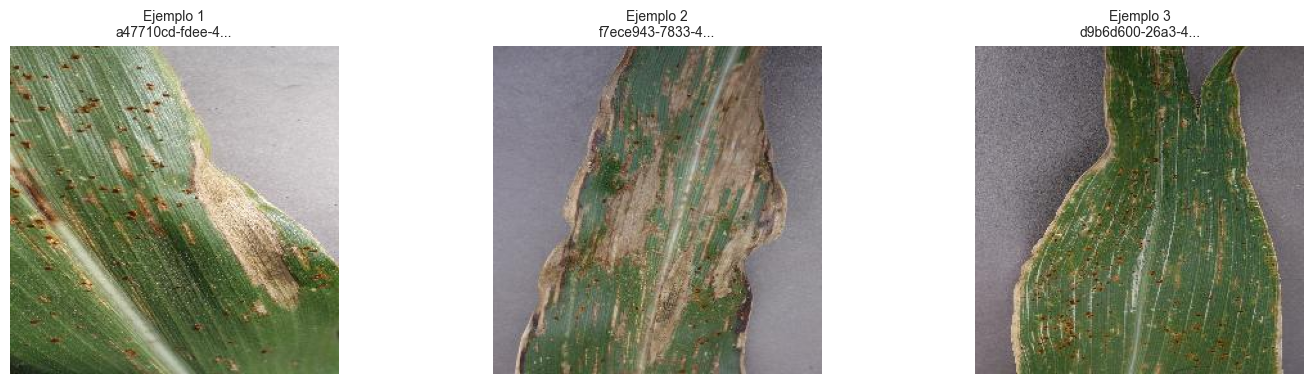


 MOSTRANDO EJEMPLOS: Corn_(maize)___Common_rust_


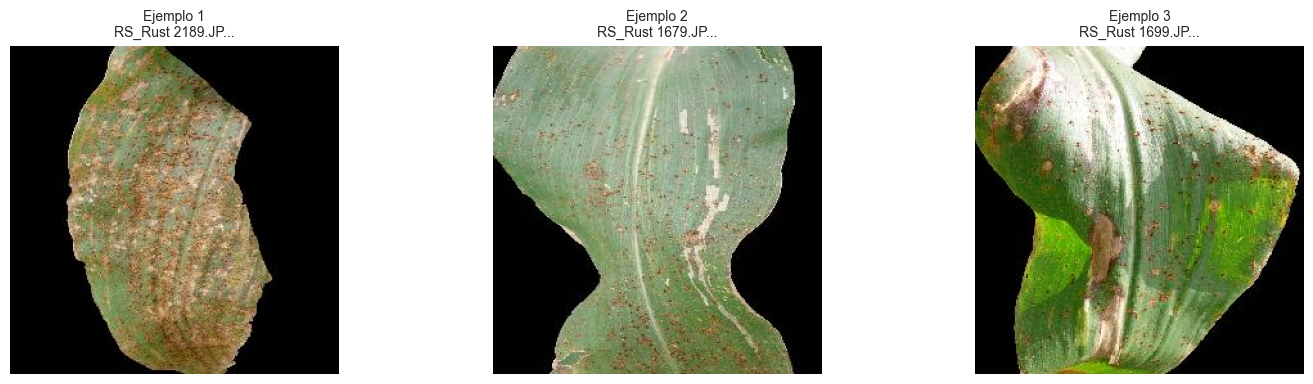


 MOSTRANDO EJEMPLOS: Corn_(maize)___Northern_Leaf_Blight


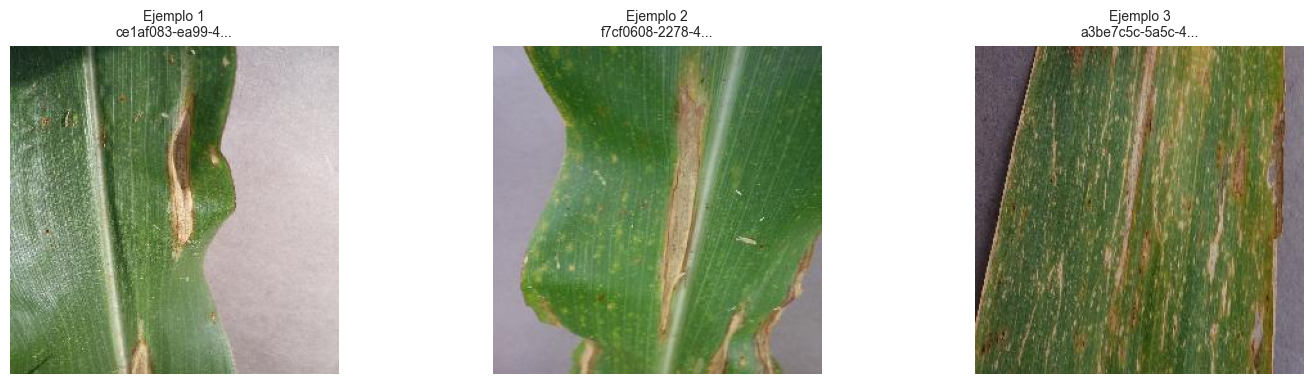


 MOSTRANDO EJEMPLOS: Corn_(maize)___healthy


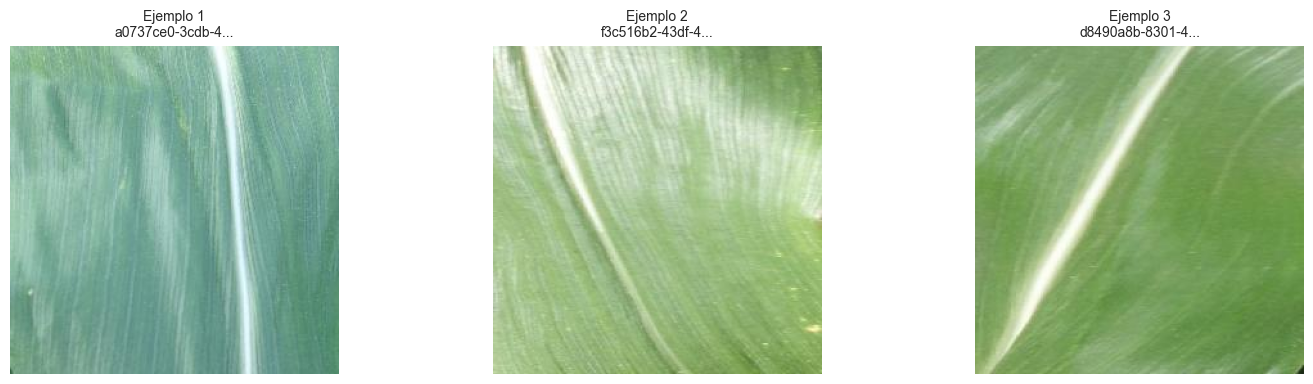

In [6]:

print("\n=== MUESTRA VISUAL DE IMÁGENES ===")

def mostrar_ejemplos_por_clase(clase, num_ejemplos=3):
    """Ejemplos de imágenes para las clases"""
    print(f"\n MOSTRANDO EJEMPLOS: {clase}")

    folder = os.path.join(DATA_COLOR, clase)
    archivos = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    # Tomar muestra aleatoria
    muestra = np.random.choice(archivos, min(num_ejemplos, len(archivos)), replace=False)

    fig, axes = plt.subplots(1, num_ejemplos, figsize=(15, 4))

    for j, archivo in enumerate(muestra):
        img_path = os.path.join(folder, archivo)
        try:
            img = Image.open(img_path)
            if num_ejemplos > 1:
                axes[j].imshow(img)
                axes[j].set_title(f'Ejemplo {j+1}\n{archivo[:15]}...', fontsize=10)
                axes[j].axis('off')
            else:
                axes.imshow(img)
                axes.set_title(f'{clase}\n{archivo[:15]}...', fontsize=10)
                axes.axis('off')
        except Exception as e:
            if num_ejemplos > 1:
                axes[j].text(0.5, 0.5, f'Error\ncargando', ha='center', va='center')
                axes[j].axis('off')
            else:
                axes.text(0.5, 0.5, f'Error\ncargando', ha='center', va='center')
                axes.axis('off')

    plt.tight_layout()
    plt.show()

# Mostrar ejemplos para cada clase
for clase in clases_corn:
    mostrar_ejemplos_por_clase(clase, num_ejemplos=3)

# 6) Dimensiones de las imagenes

In [7]:

print("\n=== ANÁLISIS DE DIMENSIONES DE IMÁGENES ===")

dimensiones = []
print(" Analizando dimensiones de muestra de imágenes...")

for clase in clases_corn:
    folder = os.path.join(DATA_COLOR, clase)
    archivos = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]

    muestra = np.random.choice(archivos, min(5, len(archivos)), replace=False)

    for archivo in muestra:
        img_path = os.path.join(folder, archivo)
        try:
            with Image.open(img_path) as img:
                ancho, alto = img.size
                dimensiones.append((clase, ancho, alto, archivo))
        except Exception as e:
            continue

df_dimensiones = pd.DataFrame(dimensiones, columns=['Clase', 'Ancho', 'Alto', 'Archivo'])

print("\n ESTADÍSTICAS DE DIMENSIONES:")
print("="*60)
stats = df_dimensiones.groupby('Clase').agg({
    'Ancho': ['min', 'max', 'mean'],
    'Alto': ['min', 'max', 'mean']
}).round(0)

print(stats)
print("="*60)




=== ANÁLISIS DE DIMENSIONES DE IMÁGENES ===
 Analizando dimensiones de muestra de imágenes...

 ESTADÍSTICAS DE DIMENSIONES:
                                                   Ancho             Alto  \
                                                     min  max   mean  min   
Clase                                                                       
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot   256  256  256.0  256   
Corn_(maize)___Common_rust_                          256  256  256.0  256   
Corn_(maize)___Northern_Leaf_Blight                  256  256  256.0  256   
Corn_(maize)___healthy                               256  256  256.0  256   

                                                                
                                                    max   mean  
Clase                                                           
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot  256  256.0  
Corn_(maize)___Common_rust_                         256  256.0  
Corn_(mai

# Fase 2 del proyecto Aprendizaje Supervisado

# 7) Verificación de carpetas y detección de clases Corn


In [8]:
#  Verificar que exista la ruta y detectar carpetas que empiezan con "Corn"
# (Si clases_corn ya fue definida en la celda de análisis estructural, esta celda la redefinirá)
if not os.path.isdir(DATA_COLOR):
    raise FileNotFoundError(f"No se encontró la carpeta: {DATA_COLOR}. Por favor verifica la ruta.")

clases_corn = [d for d in os.listdir(DATA_COLOR) if d.startswith("Corn")]
clases_corn = sorted(clases_corn)
print("Clases detectadas:", clases_corn)

if len(clases_corn) == 0:
    raise RuntimeError("No se detectaron carpetas que empiecen por 'Corn' en la ruta. Revisa la estructura.")


Clases detectadas: ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy']


# 8)  Carga y extraccion de features (mean / std)


In [9]:
# 4) Cargar imágenes, extraer mean/std
data = []

for label in clases_corn:
    folder = os.path.join(DATA_COLOR, label)
    files = [f for f in os.listdir(folder) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    print(f"Cargando {label}: {len(files)} imágenes")
    for file in tqdm(files, desc=f"Cargando {label}"):
        try:
            img_path = os.path.join(folder, file)
            img = Image.open(img_path).convert("RGB").resize((64,64))
            arr = np.array(img)/255.0
            mean = arr.mean(axis=(0,1))
            std = arr.std(axis=(0,1))
            features = np.concatenate([mean,std])
            data.append([*features, label])
        except Exception as e:
            # no interrumpimos el proceso por una imagen corrupta
            continue

columns = ['mean_R','mean_G','mean_B','std_R','std_G','std_B','label']
df = pd.DataFrame(data, columns=columns)
df['label'] = df['label'].str.strip()

print("Tamaño del dataset:", df.shape)
print("\nCantidad de imágenes por clase:")
print(df['label'].value_counts())


Cargando Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 imágenes


Cargando Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 100%|██████████| 513/513 [00:04<00:00, 116.70it/s]


Cargando Corn_(maize)___Common_rust_: 1192 imágenes


Cargando Corn_(maize)___Common_rust_: 100%|██████████| 1192/1192 [00:09<00:00, 121.01it/s]


Cargando Corn_(maize)___Northern_Leaf_Blight: 985 imágenes


Cargando Corn_(maize)___Northern_Leaf_Blight: 100%|██████████| 985/985 [00:08<00:00, 112.47it/s]


Cargando Corn_(maize)___healthy: 1162 imágenes


Cargando Corn_(maize)___healthy: 100%|██████████| 1162/1162 [00:13<00:00, 88.18it/s]

Tamaño del dataset: (3852, 7)

Cantidad de imágenes por clase:
label
Corn_(maize)___Common_rust_                           1192
Corn_(maize)___healthy                                1162
Corn_(maize)___Northern_Leaf_Blight                    985
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot     513
Name: count, dtype: int64


Distribucion de las Clases

In [10]:


print(df.describe().T)


         count      mean       std       min       25%       50%       75%  \
mean_R  3852.0  0.437450  0.099326  0.106149  0.375077  0.437819  0.490859   
mean_G  3852.0  0.498193  0.124288  0.148910  0.418382  0.479227  0.565368   
mean_B  3852.0  0.378561  0.114039  0.036564  0.300582  0.375029  0.441460   
std_R   3852.0  0.169055  0.060201  0.036822  0.121407  0.151416  0.218831   
std_G   3852.0  0.156670  0.075201  0.032866  0.093640  0.127792  0.230169   
std_B   3852.0  0.164732  0.043657  0.033914  0.131966  0.162705  0.197038   

             max  
mean_R  0.781010  
mean_G  0.856813  
mean_B  0.771378  
std_R   0.354851  
std_G   0.369244  
std_B   0.336927  


# 9) Preparación para ML clásico: split train/test, scaling


In [11]:
#  Split train/test y escalado
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=seed
)

scaler = StandardScaler() # Esto es para normalizar
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Tamaño train:", X_train.shape, " | Tamaño test:", X_test.shape)


Tamaño train: (2696, 6)  | Tamaño test: (1156, 6)


# 10) Modelos ML: Decision Tree, Random Forest, SVM


In [12]:
#  Entrenamiento de modelos
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=seed),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=seed),
    "SVM": SVC(kernel='rbf', random_state=seed)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n=== {name} ===")
    print(classification_report(y_test, y_pred))
    results[name] = acc



=== Decision Tree ===
                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.37      0.38      0.38       154
                       Corn_(maize)___Common_rust_       0.96      0.96      0.96       358
               Corn_(maize)___Northern_Leaf_Blight       0.69      0.69      0.69       295
                            Corn_(maize)___healthy       0.97      0.96      0.97       349

                                          accuracy                           0.81      1156
                                         macro avg       0.75      0.75      0.75      1156
                                      weighted avg       0.82      0.81      0.81      1156


=== Random Forest ===
                                                    precision    recall  f1-score   support

Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.55      0.29      0.38       154
                       Corn_(m

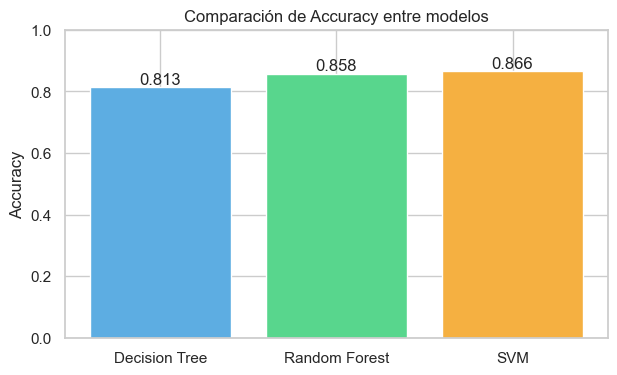

Resultados resumen:
Decision Tree: 0.813
Random Forest: 0.858
SVM: 0.866


In [13]:
#  Comparación visual de accuracies
plt.figure(figsize=(7,4))
plt.bar(results.keys(), results.values(), color=['#5DADE2','#58D68D','#F5B041'])
plt.title("Comparación de Accuracy entre modelos")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
for i,(k,v) in enumerate(results.items()):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center')
plt.show()

print("Resultados resumen:")
for k,v in results.items():
    print(f"{k}: {v:.3f}")


# 11) Validación cruzada (KFold)


In [14]:
#  KFold 5-fold en train
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
    print(f"{name} | Accuracy promedio (5-fold): {scores.mean():.3f} ± {scores.std():.3f}")


Decision Tree | Accuracy promedio (5-fold): 0.805 ± 0.007
Random Forest | Accuracy promedio (5-fold): 0.857 ± 0.010
SVM | Accuracy promedio (5-fold): 0.871 ± 0.010


# 12) Matriz de confusión del mejor modelo


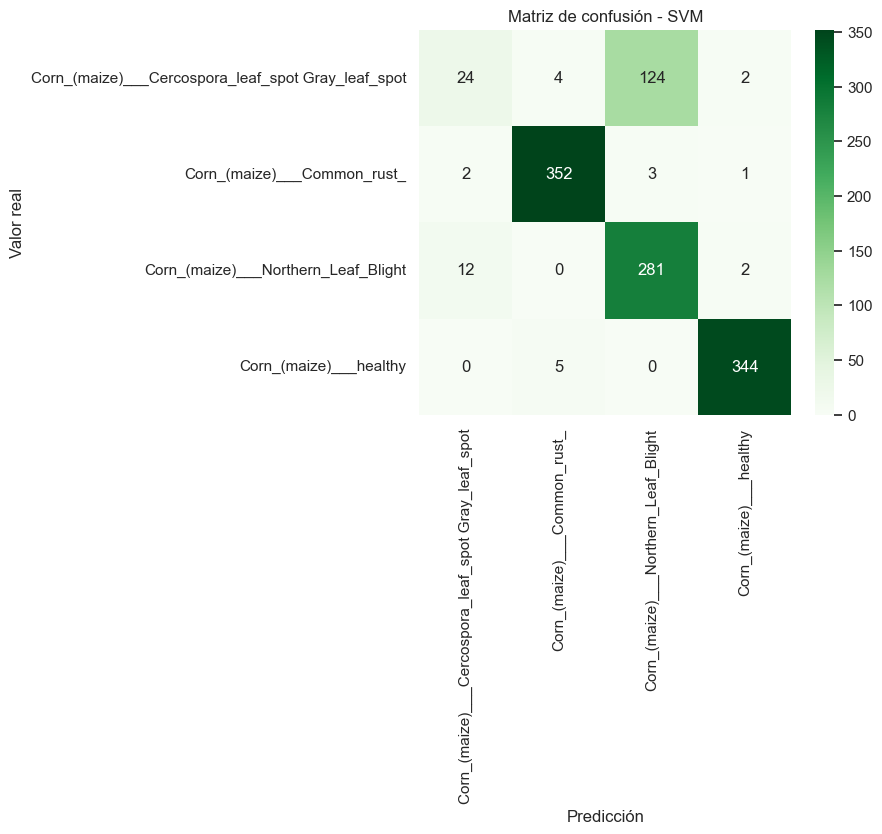

Mejor modelo: SVM


In [15]:
# ) Matriz confusión para el mejor modelo
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]

y_pred_best = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.title(f"Matriz de confusión - {best_model_name}")
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

print(f"Mejor modelo: {best_model_name}")


# 13) Curvas de aprendizaje — SVM, Decision Tree, Random Forest


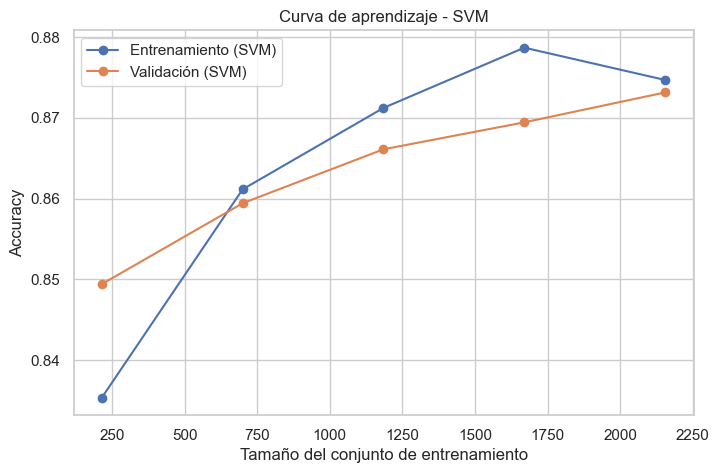

In [16]:
#  Curva de aprendizaje - SVM
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=seed)
train_sizes_svm, train_scores_svm, val_scores_svm = learning_curve(
    svm_classifier,
    X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)
train_mean_svm = np.mean(train_scores_svm, axis=1)
val_mean_svm = np.mean(val_scores_svm, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_svm, train_mean_svm, 'o-', label="Entrenamiento (SVM)")
plt.plot(train_sizes_svm, val_mean_svm, 'o-', label="Validación (SVM)")
plt.title("Curva de aprendizaje - SVM")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


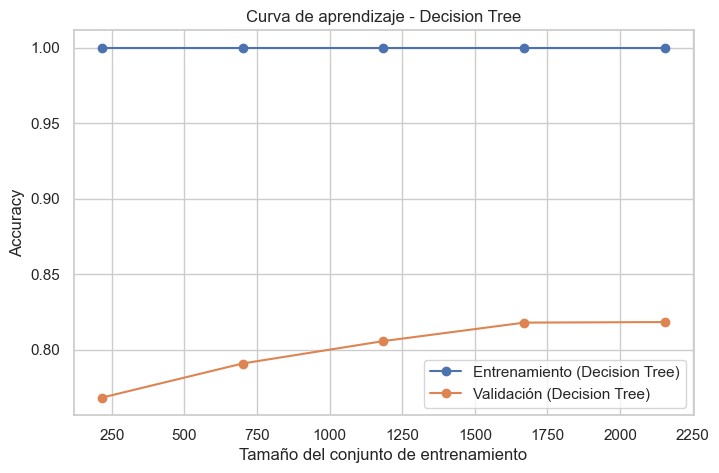

In [17]:
# ) Curva de aprendizaje - Decision Tree
dt_classifier = DecisionTreeClassifier(random_state=seed)
train_sizes_dt, train_scores_dt, val_scores_dt = learning_curve(
    dt_classifier,
    X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)
train_mean_dt = np.mean(train_scores_dt, axis=1)
val_mean_dt = np.mean(val_scores_dt, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes_dt, train_mean_dt, 'o-', label="Entrenamiento (Decision Tree)")
plt.plot(train_sizes_dt, val_mean_dt, 'o-', label="Validación (Decision Tree)")
plt.title("Curva de aprendizaje - Decision Tree")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


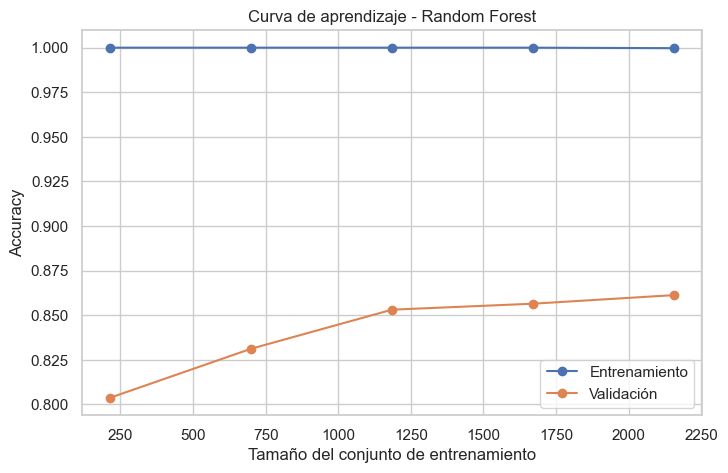

In [18]:
# ) Curva de aprendizaje - Random Forest
train_sizes, train_scores, val_scores = learning_curve(
    RandomForestClassifier(n_estimators=100, random_state=seed),
    X_train_scaled, y_train, cv=5,
    train_sizes=np.linspace(0.1, 1.0, 5),
    scoring='accuracy', n_jobs=-1
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label="Entrenamiento")
plt.plot(train_sizes, val_mean, 'o-', label="Validación")
plt.title("Curva de aprendizaje - Random Forest")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# 14) Deep Learning — MLP


In [19]:
#  Deep Learning: reproducir tu MLP (copiado)
# Verifica que root_dir exista (si usas otra ruta edita)
root_dir = DATA_COLOR

# Orden de clases (igual que antes)
class_names_used = [
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___healthy",
    "Corn_(maize)___Northern_Leaf_Blight"
]

img_size_raw = (256, 256)   # tamaño de carga desde disco
target_size = (128, 128)    # tamaño para el MLP (reduce parámetros)
val_split = 0.2
batch = 32
num_classes = len(class_names_used)

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="training",
    seed=seed,
    shuffle=True,
    batch_size=batch,
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    root_dir,
    labels="inferred",
    label_mode="int",
    class_names=class_names_used,
    image_size=img_size_raw,
    color_mode="rgb",
    validation_split=val_split,
    subset="validation",
    seed=seed,
    shuffle=False,
    batch_size=batch,
)

print("Orden de clases (fijo):", class_names_used)


Found 3852 files belonging to 4 classes.
Using 3082 files for training.
Found 3852 files belonging to 4 classes.
Using 770 files for validation.
Orden de clases (fijo): ['Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight']


## Preprocesamiento

In [40]:
# ) Preprocesamiento para MLP
@tf.function
def preprocess_batch_for_mlp(x, y):
    x = tf.image.resize(x, target_size)
    x = tf.cast(x, tf.float32)
    maxv = tf.reduce_max(x, axis=[1,2,3], keepdims=True)
    x = tf.where(maxv > 1.0, x / 255.0, x)
    x = tf.reshape(x, (tf.shape(x)[0], -1))
    return x, tf.cast(y, tf.int32)

train_ds_pp = train_ds_raw.map(preprocess_batch_for_mlp, num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(8192, seed=seed).prefetch(tf.data.AUTOTUNE)
val_ds_pp   = val_ds_raw.map(preprocess_batch_for_mlp,   num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)


#15) Definicion del MLP

In [41]:
# Definición del MLP 
reg = tf.keras.regularizers.l2(1e-4)
model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(target_size[0]*target_size[1]*3,)),
    tf.keras.layers.Dense(1024, activation="relu", kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation="relu", kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=reg),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-5, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=6, restore_best_weights=True, verbose=1),
]


c:\Users\juand\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#16) Estimar los class weights

In [42]:
# ) Estimar class weights 
counts = np.zeros(num_classes, dtype=np.int64)
for _, yb in train_ds_raw.unbatch().batch(4096):
    y_np = yb.numpy()
    for i in range(num_classes):
        counts[i] += np.sum(y_np == i)
class_weights = {i: float(np.sum(counts)/max(counts[i],1)) for i in range(num_classes)}
print("Distribución clases (train):", dict(zip(class_names_used, counts.tolist())))
print("Class weights:", class_weights)


Distribución clases (train): {'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 427, 'Corn_(maize)___Common_rust_': 942, 'Corn_(maize)___healthy': 950, 'Corn_(maize)___Northern_Leaf_Blight': 763}
Class weights: {0: 7.217798594847775, 1: 3.2717622080679405, 2: 3.2442105263157894, 3: 4.039318479685452}


#17) Entrenamineto del MLP

In [43]:
#  Entrenamiento del MLP
history = model.fit(
    train_ds_pp,
    validation_data=val_ds_pp,
    epochs=10,
    callbacks=callbacks,
    class_weight=class_weights,  
    verbose=1,
)


Epoch 1/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 53s 513ms/step - accuracy: 0.7485 - loss: 3.1755 - val_accuracy: 0.3896 - val_loss: 2.0074 - learning_rate: 0.0010
Epoch 2/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 52s 533ms/step - accuracy: 0.8225 - loss: 2.2321 - val_accuracy: 0.8481 - val_loss: 1.0044 - learning_rate: 0.0010
Epoch 3/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 525ms/step - accuracy: 0.8533 - loss: 2.0542 - val_accuracy: 0.8429 - val_loss: 0.8913 - learning_rate: 0.0010
Epoch 4/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 50s 514ms/step - accuracy: 0.8819 - loss: 1.8350 - val_accuracy: 0.8364 - val_loss: 0.8684 - learning_rate: 0.0010
Epoch 5/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 522ms/step - accuracy: 0.8838 - loss: 1.7162 - val_accuracy: 0.8273 - val_loss: 0.9221 - learning_rate: 0.0010
Epoch 6/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 523ms/step - accuracy: 0.9137 - loss: 1.5124 - val_accuracy: 0.8247 - val_loss: 0.9362 - learning_rate: 0.0010
Epoch 7/10
97/97 ━━━━━━━━━━━━━━━━━━━━ 51s 526ms/step - accuracy: 0.9166 - loss: 1.

#18) Envolver modelo para inferencia

In [44]:
#  Envolver modelo para inferencia 
TARGET_SIZE = (128, 128)
inp = keras.Input(shape=(None, None, 3))
z = layers.Resizing(TARGET_SIZE[0], TARGET_SIZE[1])(inp)
z = layers.Rescaling(1./255)(z)
z = layers.Flatten()(z)
out = model(z)
model_infer = keras.Model(inp, out)
model_infer.compile(
    optimizer=model.optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

test_loss, test_acc = model_infer.evaluate(val_ds_raw, verbose=1)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.8662 - loss: 0.8540
Test loss: 0.8539929389953613
Test accuracy: 0.866233766078949


#19) Evaluar el modelo

In [45]:
# ======================== EVALUACIÓN =========================

# ============== PREDICCIÓN DE UNA IMAGEN EXTERNA =============
def predict_external_image(image_path: str):
    raw = tf.io.read_file(image_path)
    img = tf.image.decode_image(raw, channels=3, expand_animations=False)  # RGB
    probs = model_infer.predict(img[None, ...], verbose=0)[0]
    pred_idx = int(np.argmax(probs))
    pred_name = class_names_used[pred_idx]

    plt.imshow(img.numpy().astype(np.uint8)); plt.axis('off')
    plt.title(f"Pred: {pred_name} (p={probs[pred_idx]:.2f})")
    plt.show()
    return pred_name, probs

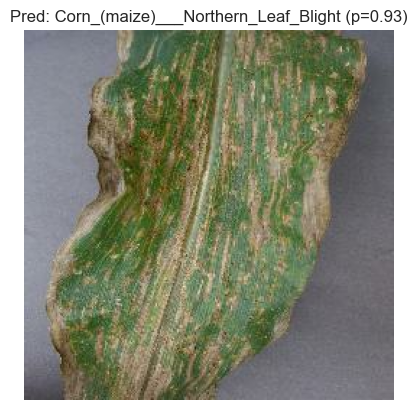

('Corn_(maize)___Northern_Leaf_Blight',
 array([7.3232487e-02, 1.1558655e-04, 4.8344373e-05, 9.2660367e-01],
       dtype=float32))

In [26]:

vegetable_leaf = "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot"
specific_img = "00a20f6f-e8bd-4453-9e25-36ea70feb626___RS_GLSp 4655.JPG"
early_blight = os.path.join(DATA_COLOR, vegetable_leaf, specific_img)
# Ejecuta
predict_external_image(early_blight)

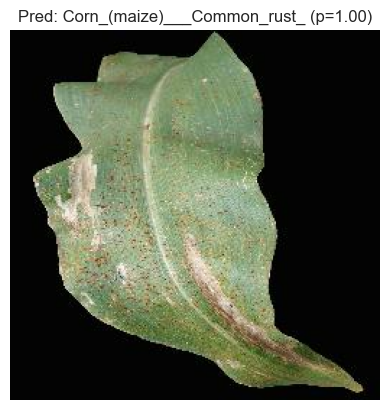

('Corn_(maize)___Common_rust_',
 array([2.3482204e-07, 9.9999976e-01, 5.6171201e-10, 4.1582890e-08],
       dtype=float32))

In [27]:

vegetable_leaf = "Corn_(maize)___Common_rust_"
specific_img = "RS_Rust 1563.JPG"

late_blight = os.path.join(DATA_COLOR, vegetable_leaf, specific_img) 

predict_external_image(late_blight)

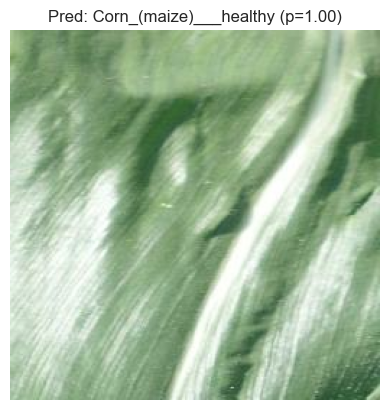

('Corn_(maize)___healthy',
 array([7.9514575e-05, 8.8268371e-07, 9.9990952e-01, 1.0044785e-05],
       dtype=float32))

In [28]:

vegetable_leaf = "Corn_(maize)___healthy"
specific_img = "254d1f23-8a22-4f21-9d5e-0c66733f102f___R.S_HL 8083 copy.jpg"

late_blight_2 = os.path.join(DATA_COLOR, vegetable_leaf, specific_img)

predict_external_image(late_blight_2)


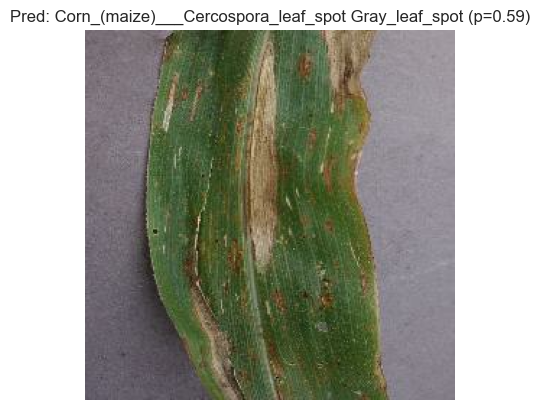

('Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 array([5.9496123e-01, 5.9673690e-05, 4.5714132e-04, 4.0452194e-01],
       dtype=float32))

In [29]:

vegetable_leaf = "Corn_(maize)___Northern_Leaf_Blight"
specific_img = "00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG"

Healthy = os.path.join(DATA_COLOR, vegetable_leaf, specific_img)

predict_external_image(Healthy)

# Fase 3 del proyecto Aprendizaje No Supervisado

#20) Extraer features de todo el dataset

In [30]:

print("=== EXTRACCIÓN DE FEATURES - DATASET COMPLETO ===")

# Crea modelo para extraer features (penúltima capa del MLP)
feature_model = Model(inputs=model.input, outputs=model.layers[-2].output)
print(" Modelo para extracción de features creado")

def extraer_features_completas(dataset):
    """Extrae features y labels de un dataset completo"""
    features_list = []
    labels_list = []

    for imgs, labels in dataset:
        # Extraer features del batch actual
        feats = feature_model(imgs, training=False).numpy()
        features_list.append(feats)
        labels_list.append(labels.numpy())

    # Combinar todos los batches
    features = np.vstack(features_list)
    labels = np.hstack(labels_list)
    return features, labels

# Extraer features del training set
print(" Extrayendo features del training set...")
features_train, labels_train = extraer_features_completas(train_ds_pp)

# Extraer features del validation set
print(" Extrayendo features del validation set...")
features_val, labels_val = extraer_features_completas(val_ds_pp)

# Combinar training y validation
features_full = np.vstack([features_train, features_val])
labels_full = np.hstack([labels_train, labels_val])

print("\n DATASET COMPLETO - ESTADÍSTICAS:")
print(f"   - Features shape: {features_full.shape}")
print(f"   - Labels shape: {labels_full.shape}")

# Mostrar distribución de clases
unique_labels, counts = np.unique(labels_full, return_counts=True)
print("   - Distribución por clase:")
for label, count in zip(unique_labels, counts):
    nombre_clase = class_names_used[label]
    print(f"     {nombre_clase}: {count} muestras")

print(" Extracción de features completada")

=== EXTRACCIÓN DE FEATURES - DATASET COMPLETO ===
 Modelo para extracción de features creado
 Extrayendo features del training set...
 Extrayendo features del validation set...

 DATASET COMPLETO - ESTADÍSTICAS:
   - Features shape: (3852, 128)
   - Labels shape: (3852,)
   - Distribución por clase:
     Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 427 muestras
     Corn_(maize)___Common_rust_: 942 muestras
     Corn_(maize)___healthy: 950 muestras
     Corn_(maize)___Northern_Leaf_Blight: 1533 muestras
 Extracción de features completada


#21) Reduccion de Dimensionalidad

In [32]:

print("\n=== REDUCCIÓN DE DIMENSIONALIDAD ===")

#  PCA para clustering
print(" Aplicando PCA...")
pca_10d = PCA(n_components=10, random_state=42)
features_pca = pca_10d.fit_transform(features_full)
varianza_explicada = pca_10d.explained_variance_ratio_.sum()
print(f" PCA 10D completado - Varianza explicada: {varianza_explicada:.3f}")

#  t-SNE para visualización
print(" Aplicando t-SNE...")
tsne_2d = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
features_tsne = tsne_2d.fit_transform(features_full)
print(" t-SNE 2D completado")

# Escalado para DBSCAN
print(" Escalando features...")
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_full)
print(" Features escaladas")

print(" RESUMEN DIMENSIONALIDAD:")
print(f"   - Original: {features_full.shape[1]} dimensiones")
print(f"   - PCA: 10 dimensiones ({varianza_explicada:.1%} varianza)")
print(f"   - t-SNE: 2 dimensiones (solo visualización)")


=== REDUCCIÓN DE DIMENSIONALIDAD ===
 Aplicando PCA...
 PCA 10D completado - Varianza explicada: 0.916
 Aplicando t-SNE...
 t-SNE 2D completado
 Escalando features...
 Features escaladas
 RESUMEN DIMENSIONALIDAD:
   - Original: 128 dimensiones
   - PCA: 10 dimensiones (91.6% varianza)
   - t-SNE: 2 dimensiones (solo visualización)


#22) Aplicacion de metodos de Clustering

In [33]:

print("\n=== APLICACIÓN DE MÉTODOS DE CLUSTERING ===")


#  KMeans
print(" Aplicando KMeans...")
kmeans = KMeans(n_clusters=len(class_names_used), random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_pca)
print(" KMeans completado")

#  DBSCAN
print(" Aplicando DBSCAN...")
dbscan = DBSCAN(eps=0.8, min_samples=5)
dbscan_labels = dbscan.fit_predict(features_scaled)
print(" DBSCAN completado")

#  Agglomerative Clustering
print(" Aplicando Agglomerative Clustering...")
agglo = AgglomerativeClustering(n_clusters=len(class_names_used), linkage='ward')
agglo_labels = agglo.fit_predict(features_pca)
print(" Agglomerative Clustering completado")

print(" CLUSTERING APLICADO:")
print(f"   - KMeans: {len(np.unique(kmeans_labels))} clusters")
print(f"   - DBSCAN: {len(np.unique(dbscan_labels))} clusters")
print(f"   - Agglomerative: {len(np.unique(agglo_labels))} clusters")


=== APLICACIÓN DE MÉTODOS DE CLUSTERING ===
 Aplicando KMeans...
 KMeans completado
 Aplicando DBSCAN...
 DBSCAN completado
 Aplicando Agglomerative Clustering...
 Agglomerative Clustering completado
 CLUSTERING APLICADO:
   - KMeans: 4 clusters
   - DBSCAN: 1 clusters
   - Agglomerative: 4 clusters


#23) Evaluacion con metricas

In [34]:

print("\n=== EVALUACIÓN CON MÉTRICAS ===")

def evaluar_metodo_clustering(labels, nombre_metodo, labels_reales, features):
    """Evalúa un método de clustering con métricas"""
    # Adjusted Rand Index (comparación con labels reales)
    ari = adjusted_rand_score(labels_reales, labels)

    # Silhouette Score (calidad interna de clusters)
    if len(np.unique(labels)) > 1:
        silhouette = silhouette_score(features, labels)
    else:
        silhouette = -1

    print(f" {nombre_metodo}:")
    print(f"   - Clusters encontrados: {len(np.unique(labels))}")
    print(f"   - Adjusted Rand Index: {ari:.3f}")
    print(f"   - Silhouette Score: {silhouette:.3f}")

    return ari, silhouette

# Evaluar cada método
print(" EVALUANDO MÉTRICAS DE CALIDAD...")
ari_kmeans, sil_kmeans = evaluar_metodo_clustering(kmeans_labels, "KMEANS", labels_full, features_pca)
ari_dbscan, sil_dbscan = evaluar_metodo_clustering(dbscan_labels, "DBSCAN", labels_full, features_scaled)
ari_agglo, sil_agglo = evaluar_metodo_clustering(agglo_labels, "AGGLOMERATIVE", labels_full, features_pca)

# Determinar mejor método
metodos = ['KMeans', 'DBSCAN', 'Agglomerative']
aris = [ari_kmeans, ari_dbscan, ari_agglo]
mejor_idx = np.argmax(aris)
mejor_metodo = metodos[mejor_idx]
mejor_ari = aris[mejor_idx]

print(f"\n MEJOR MÉTODO: {mejor_metodo} (ARI: {mejor_ari:.3f})")


=== EVALUACIÓN CON MÉTRICAS ===
 EVALUANDO MÉTRICAS DE CALIDAD...
 KMEANS:
   - Clusters encontrados: 4
   - Adjusted Rand Index: 0.714
   - Silhouette Score: 0.501
 DBSCAN:
   - Clusters encontrados: 1
   - Adjusted Rand Index: 0.000
   - Silhouette Score: -1.000
 AGGLOMERATIVE:
   - Clusters encontrados: 4
   - Adjusted Rand Index: 0.722
   - Silhouette Score: 0.491

 MEJOR MÉTODO: Agglomerative (ARI: 0.722)


#24) Visualizacion de Resultados


=== VISUALIZACIÓN DE RESULTADOS ===


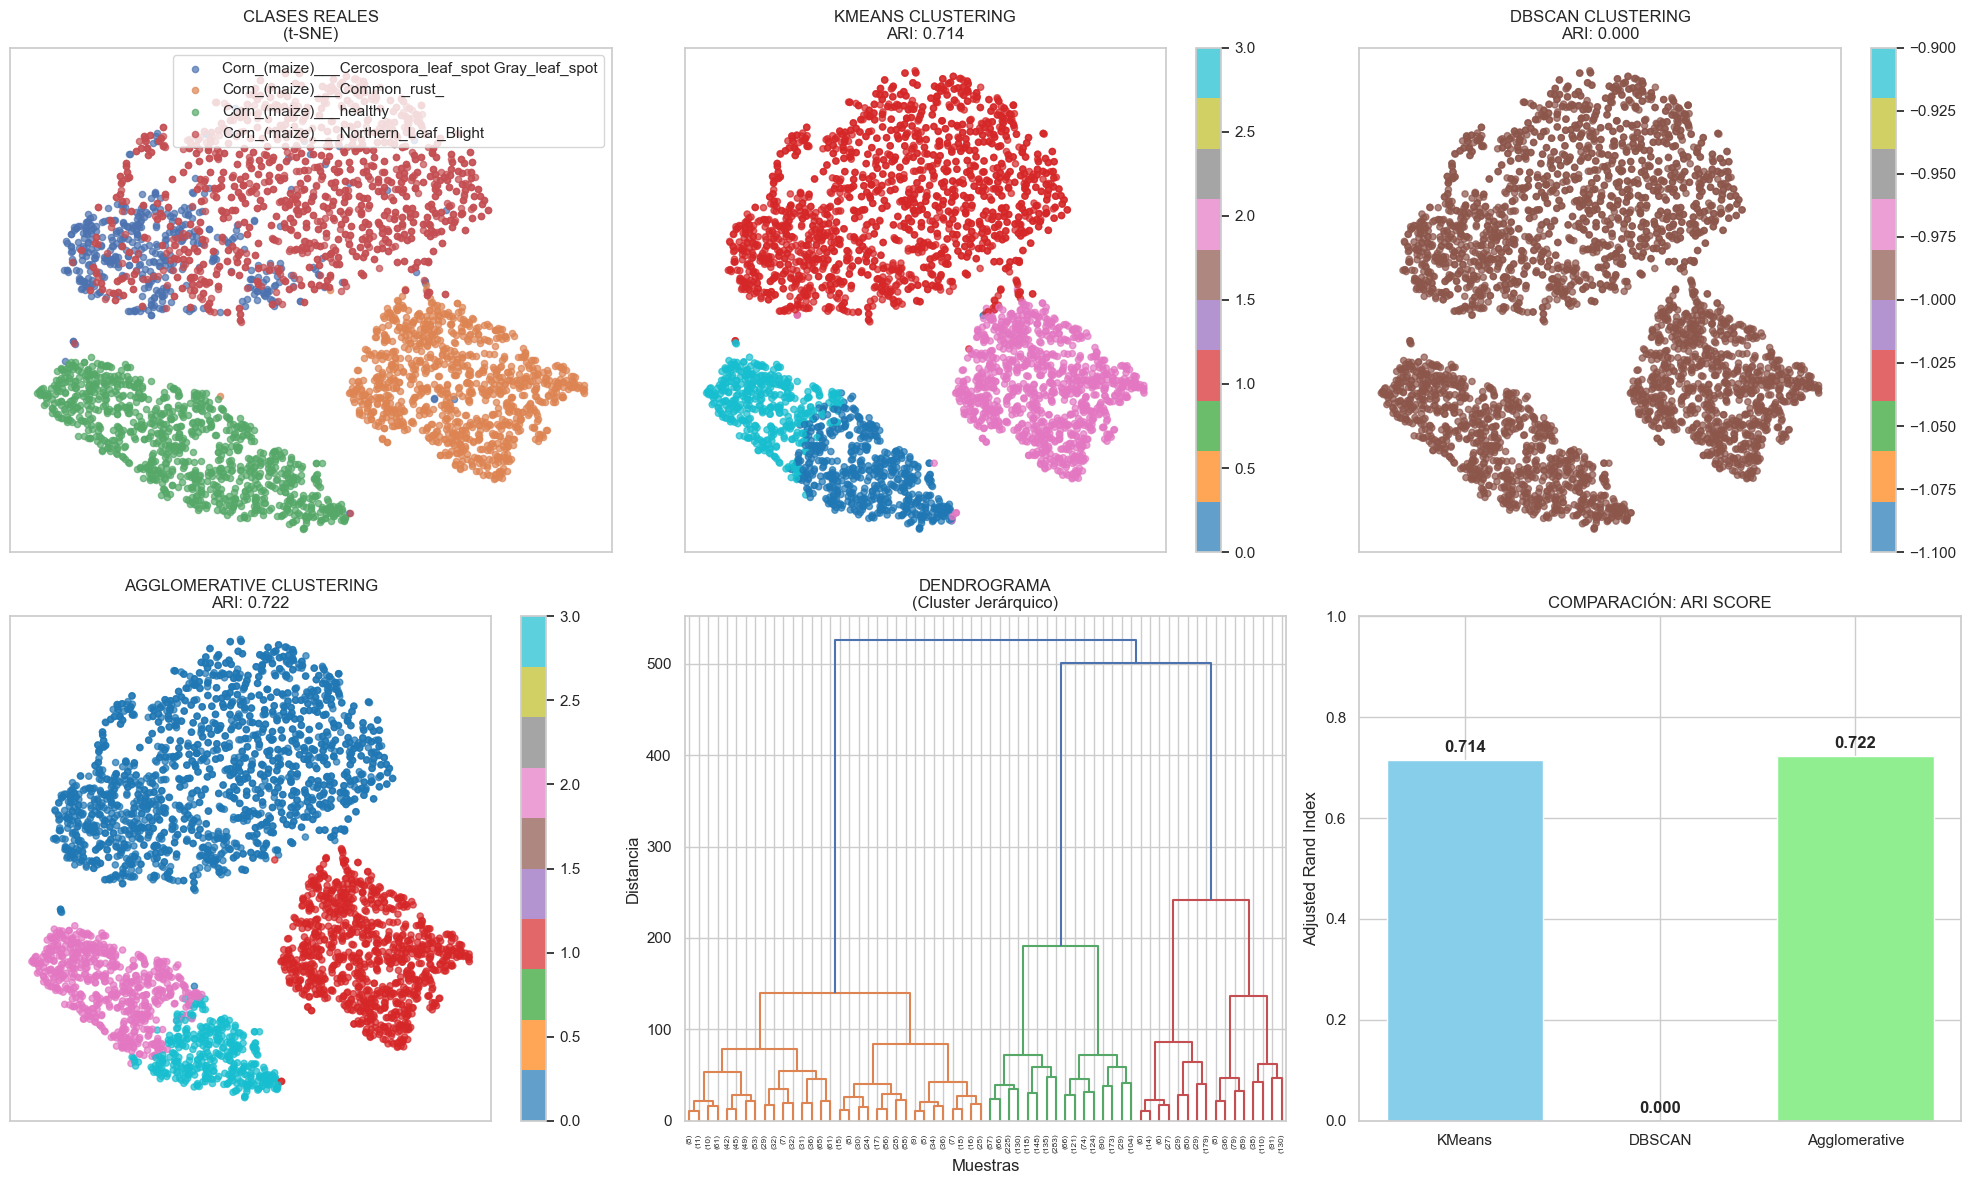

 Visualizaciones completadas


In [35]:

print("\n=== VISUALIZACIÓN DE RESULTADOS ===")

plt.figure(figsize=(20, 12))

#  CLASES REALES
plt.subplot(2, 3, 1)
for i in range(len(class_names_used)):
    mask = labels_full == i
    plt.scatter(features_tsne[mask, 0], features_tsne[mask, 1],
               label=class_names_used[i], alpha=0.7, s=20)
plt.title("CLASES REALES\n(t-SNE)")
plt.legend()
plt.xticks([]); plt.yticks([])

#  KMEANS
plt.subplot(2, 3, 2)
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                     c=kmeans_labels, cmap='tab10', alpha=0.7, s=20)
plt.title(f"KMEANS CLUSTERING\nARI: {ari_kmeans:.3f}")
plt.colorbar(scatter)
plt.xticks([]); plt.yticks([])

#  DBSCAN
plt.subplot(2, 3, 3)
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                     c=dbscan_labels, cmap='tab10', alpha=0.7, s=20)
plt.title(f"DBSCAN CLUSTERING\nARI: {ari_dbscan:.3f}")
plt.colorbar(scatter)
plt.xticks([]); plt.yticks([])

# AGGLOMERATIVE
plt.subplot(2, 3, 4)
scatter = plt.scatter(features_tsne[:, 0], features_tsne[:, 1],
                     c=agglo_labels, cmap='tab10', alpha=0.7, s=20)
plt.title(f"AGGLOMERATIVE CLUSTERING\nARI: {ari_agglo:.3f}")
plt.colorbar(scatter)
plt.xticks([]); plt.yticks([])

#  DENDROGRAMA
plt.subplot(2, 3, 5)
linkage_matrix = hierarchy.linkage(features_pca, method='ward')
hierarchy.dendrogram(linkage_matrix, truncate_mode='level', p=5)
plt.title("DENDROGRAMA\n(Cluster Jerárquico)")
plt.xlabel("Muestras")
plt.ylabel("Distancia")

#  COMPARACIÓN ARI
plt.subplot(2, 3, 6)
metodos_nombres = ['KMeans', 'DBSCAN', 'Agglomerative']
ari_valores = [ari_kmeans, ari_dbscan, ari_agglo]

bars = plt.bar(metodos_nombres, ari_valores,
               color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title("COMPARACIÓN: ARI SCORE")
plt.ylabel("Adjusted Rand Index")
plt.ylim(0, 1)

# Añadir valores en las barras
for bar, valor in zip(bars, ari_valores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(" Visualizaciones completadas")

#25) Metodo del codo

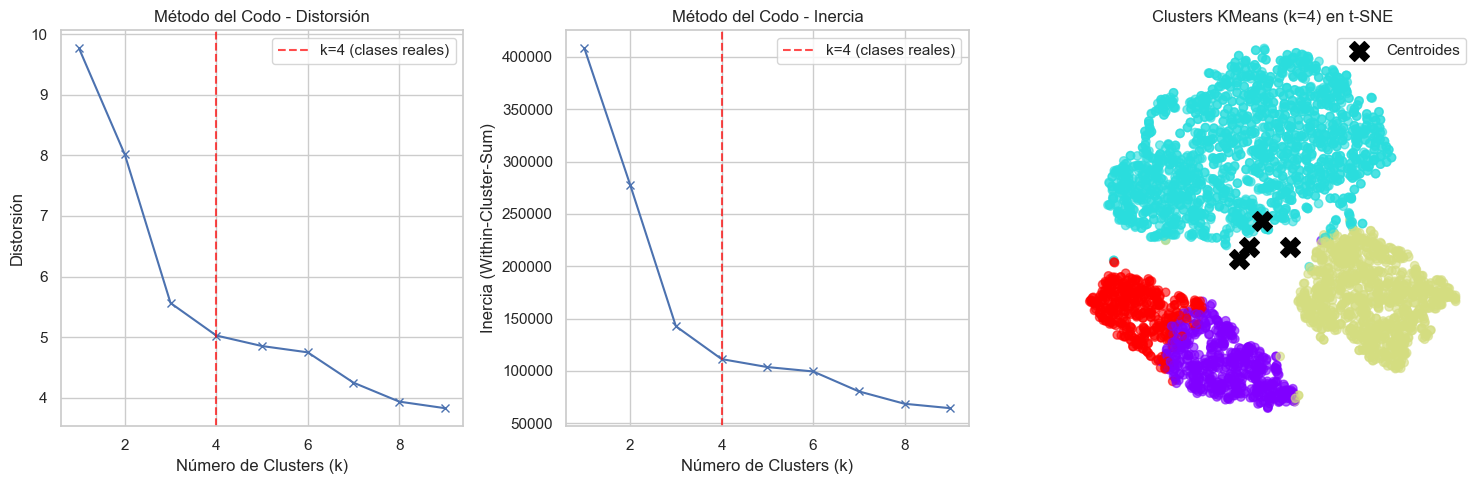

 INTERPRETACIÓN DEL MÉTODO DEL CODO:
• Inercia con k=4: 111350.35
• ¿El codo sugiere k=4? →  NO - el codo sugiere otro k
   Pero k=4 está justificado por las clases biológicas reales


In [36]:

from scipy.spatial.distance import cdist

# Usar las features del PCA (mejor para clustering)
X = features_pca  # En lugar de features crudas

distortions = []
wss = []
K = range(1, 10)

for k in K:
    kmeanModel = KMeans(n_clusters=k, n_init='auto', random_state=42).fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    wss.append(kmeanModel.inertia_)

plt.figure(figsize=(15, 5))

# Gráfica 1: Distortion
plt.subplot(1, 3, 1)
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Distorsión')
plt.title('Método del Codo - Distorsión')
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='k=4 (clases reales)')
plt.legend()

# Gráfica 2: Inertia (WSS)
plt.subplot(1, 3, 2)
plt.plot(K, wss, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia (Within-Cluster-Sum)')
plt.title('Método del Codo - Inercia')
plt.axvline(x=4, color='red', linestyle='--', alpha=0.7, label='k=4 (clases reales)')
plt.legend()

# Gráfica 3: Visualización con k=4
plt.subplot(1, 3, 3)
kmeanModel = KMeans(n_clusters=4, n_init='auto', random_state=42).fit(X)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeanModel.labels_, cmap='rainbow', alpha=0.6)
plt.scatter(kmeanModel.cluster_centers_[:, 0], kmeanModel.cluster_centers_[:, 1],
           color='black', marker='X', s=200, label='Centroides')
plt.title('Clusters KMeans (k=4) en t-SNE')
plt.legend()
plt.axis('off')

plt.tight_layout()
plt.show()

# Análisis interpretativo
print(" INTERPRETACIÓN DEL MÉTODO DEL CODO:")
print(f"• Inercia con k=4: {wss[3]:.2f}")
print(f"• ¿El codo sugiere k=4? → ", end="")

# Detección automática del codo (simplificada)
if wss[3] - wss[4] > 0.7 * (wss[2] - wss[3]):  # Heurística simple
    print(" SÍ - k=4 parece óptimo")
    print("   Esto valida que 4 clusters es una elección natural")
else:
    print(" NO - el codo sugiere otro k")
    print("   Pero k=4 está justificado por las clases biológicas reales")

#26) Analisis detallado por clase

In [37]:

print("\n=== ANÁLISIS DETALLADO POR CLASE ===")

print(" DISTRIBUCIÓN DE CLUSTERS KMEANS POR CLASE REAL:")

for i, class_name in enumerate(class_names_used):
    # Filtrar muestras de esta clase
    mask_clase = labels_full == i
    clusters_en_clase = kmeans_labels[mask_clase]

    # Contar clusters en esta clase
    clusters_unicos, conteos = np.unique(clusters_en_clase, return_counts=True)

    print(f"\n {class_name}:")
    print(f"   - Muestras totales: {mask_clase.sum()}")
    print(f"   - Clusters asignados: {len(clusters_unicos)}")

    # Mostrar distribución por cluster
    for cluster_id, count in zip(clusters_unicos, conteos):
        porcentaje = count / mask_clase.sum()
        print(f"     • Cluster {cluster_id}: {count} muestras ({porcentaje:.1%})")

    # Identificar cluster principal
    if len(conteos) > 0:
        cluster_principal = clusters_unicos[np.argmax(conteos)]
        porcentaje_principal = conteos.max() / mask_clase.sum()
        print(f"    Cluster principal: {cluster_id} ({porcentaje_principal:.1%} de la clase)")

print("\n Análisis por clase completado")


=== ANÁLISIS DETALLADO POR CLASE ===
 DISTRIBUCIÓN DE CLUSTERS KMEANS POR CLASE REAL:

 Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot:
   - Muestras totales: 427
   - Clusters asignados: 3
     • Cluster 1: 420 muestras (98.4%)
     • Cluster 2: 5 muestras (1.2%)
     • Cluster 3: 2 muestras (0.5%)
    Cluster principal: 3 (98.4% de la clase)

 Corn_(maize)___Common_rust_:
   - Muestras totales: 942
   - Clusters asignados: 3
     • Cluster 0: 2 muestras (0.2%)
     • Cluster 1: 14 muestras (1.5%)
     • Cluster 2: 926 muestras (98.3%)
    Cluster principal: 2 (98.3% de la clase)

 Corn_(maize)___healthy:
   - Muestras totales: 950
   - Clusters asignados: 3
     • Cluster 0: 535 muestras (56.3%)
     • Cluster 2: 4 muestras (0.4%)
     • Cluster 3: 411 muestras (43.3%)
    Cluster principal: 3 (56.3% de la clase)

 Corn_(maize)___Northern_Leaf_Blight:
   - Muestras totales: 1533
   - Clusters asignados: 3
     • Cluster 1: 1531 muestras (99.9%)
     • Cluster 2: 1 muestras (0.1%

#27 Interpretacion Final

In [38]:

print("\n" + "="*60)
print(" INTERPRETACIÓN FINAL DE RESULTADOS")
print("="*60)

# Interpretar calidad del clustering
if mejor_ari > 0.8:
    interpretacion = "EXCELENTE"
    explicacion = "Tu MLP aprendió features que separan perfectamente las clases"
elif mejor_ari > 0.6:
    interpretacion = "BUENA"
    explicacion = "Separación razonable entre clases, el MLP capturó la estructura principal"
elif mejor_ari > 0.4:
    interpretacion = "MODERADA"
    explicacion = "Separación aceptable, algunas enfermedades tienen características visuales similares"
else:
    interpretacion = "BAJA"
    explicacion = "Poca correspondencia, las enfermedades podrían ser visualmente muy similares"

print(f" RESULTADO GLOBAL: {interpretacion}")
print(f" {explicacion}")

print(f"\n HALLAZGOS PRINCIPALES:")
print(f"   - Mejor método: {mejor_metodo} (ARI: {mejor_ari:.3f})")
print(f"   - Features extraídas: {features_full.shape[1]} dimensiones")
print(f"   - Varianza explicada (PCA): {varianza_explicada:.1%}")
print(f"   - Total de muestras analizadas: {len(features_full)}")

print("\n RECOMENDACIONES:")
if mejor_ari < 0.7:
    print("   - Considerar usar CNN pre-entrenadas para features más robustas")
    print("   - Aplicar data augmentation para mejorar generalización")
else:
    print("   - El MLP está aprendiendo representaciones efectivas")



 INTERPRETACIÓN FINAL DE RESULTADOS
 RESULTADO GLOBAL: BUENA
 Separación razonable entre clases, el MLP capturó la estructura principal

 HALLAZGOS PRINCIPALES:
   - Mejor método: Agglomerative (ARI: 0.722)
   - Features extraídas: 128 dimensiones
   - Varianza explicada (PCA): 91.6%
   - Total de muestras analizadas: 3852

 RECOMENDACIONES:
   - El MLP está aprendiendo representaciones efectivas
